<a href="https://colab.research.google.com/github/opsabarsec/Olist/blob/master/OList_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# 1. Creation of a unique dataframe

In [0]:
# import the raw data from csv files

df_orders = pd.read_csv('olist_orders_dataset.csv',sep=',', parse_dates=['order_purchase_timestamp', 'order_estimated_delivery_date', 'order_delivered_customer_date'])
df_customers = pd.read_csv('olist_customers_dataset.csv',sep=',')
df_payments = pd.read_csv('olist_order_payments_dataset.csv',sep=',')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv',sep=',')
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv", sep=',')
df_items = pd.read_csv('olist_order_items_dataset.csv',sep=',')
df_products = pd.read_csv('olist_products_dataset.csv',sep=',')
product_translations = pd.read_csv('product_category_name_translation.csv',sep=',')
df_sellers= pd.read_csv('olist_sellers_dataset.csv',sep=',')

print(df_orders.shape,df_customers.shape,df_payments.shape, df_items.shape )
df_items[:2]

(99441, 8) (99441, 5) (103886, 5) (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [0]:
#print('\n customers col \n ',' ',df_customers.dtypes,'\n orders col \n',' ', df_orders.dtypes,'\n payments col \n ', ' ',  df_payments.dtypes,'\n reviews col \n ', ' ',df_reviews.dtypes, '\n items col \n ', ' ',df_items.dtypes, '\n products col \n ', ' ',df_products.dtypes,'\n sellers col \n ', ' ',df_sellers.dtypes, '\n geolocation col \n ',df_geolocation.dtypes)

There are two columns used to identify customers. customer_id is a customer ID token that is generated for every order. If the same customer makes multiple orders, he has multiple customer_id identifiers. What we want to use for this analysis is customer_unique_id, which is unique to each purchaser and can be used to track their purchases over time.

In [0]:
print(df_customers.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


Here is the distribution of purchases made by customers.

In [0]:
df_customers.groupby('customer_unique_id').size().value_counts() # not all customers id are unique

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

Get the product category  in English

In [0]:
df_products = df_products.merge(product_translations, how = 'left', left_on = 'product_category_name', right_on = 'product_category_name')
print(df_products.columns)

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')


In [0]:
df_order_by_customer = pd.merge(df_orders[['customer_id','order_id','order_purchase_timestamp']], df_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix']], how ='inner', on ='customer_id') 
df_order_by_customer = df_order_by_customer.drop_duplicates(keep=False) #remove duplicates 
print(df_order_by_customer.columns)
print(df_order_by_customer.shape)
print(df_order_by_customer["customer_id"].duplicated().value_counts()) 

Index(['customer_id', 'order_id', 'order_purchase_timestamp',
       'customer_unique_id', 'customer_zip_code_prefix'],
      dtype='object')
(99441, 5)
False    99441
Name: customer_id, dtype: int64


In [0]:
df_payment_and_order = df_order_by_customer.merge(df_payments, how = 'inner', left_on = 'order_id', right_on = 'order_id')
df_payment_by_customer = df_payment_and_order.groupby(['customer_unique_id','customer_id','order_id','order_purchase_timestamp']).sum().reset_index()
print(df_payment_by_customer.columns)
print(df_payment_by_customer.shape)
print(df_payment_by_customer["customer_id"].duplicated().value_counts())


Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value'],
      dtype='object')
(99440, 8)
False    99440
Name: customer_id, dtype: int64


In [0]:
import seaborn as sns
#plt.figure(figsize = (15,4))
#sns.boxplot(data = df_payment_by_customer, orient = "h")
#plt.show()

In the items dataset, each item in an order gets its separate row. The price column refers cumulative order purchase rather than individual item price. Since I only need order price, I'll group by order_id and get the amount of items for each order.

In [0]:
print(df_items.columns)
#df_items.drop_duplicates('order_id',keep='first',inplace=True) # to be revised
# calculate number of items for each order

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [0]:
print(max(df_items['order_item_id'])) # this is the maximum amount of items for one order, well above 1

21


In [0]:
df_items_paid = df_payment_by_customer.merge(df_items[['order_id','order_item_id', 'product_id', 'price', 'freight_value']], how = 'inner', left_on = 'order_id', right_on = 'order_id')


print(df_items_paid.shape)
print(df_items_paid["customer_id"].duplicated().value_counts())

(112647, 12)
False    98665
True     13982
Name: customer_id, dtype: int64


In [0]:
df_products_bought = df_items_paid.merge(df_products[['product_id','product_category_name_english']], how = 'inner', left_on = 'product_id', right_on = 'product_id')
#df_products_bought = df_items_paid.merge(df_products[['product_id','product_photos_qty', 'product_weight_g','product_category_name','product_category_name_english']], how = 'inner', left_on = 'product_id', right_on = 'product_id')
print(df_products_bought.shape)
print(df_products_bought.columns)
print(df_products_bought["customer_id"].duplicated().value_counts())
# insert a columns for the amount of products categories for each order

(112647, 13)
Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name_english'],
      dtype='object')
False    98665
True     13982
Name: customer_id, dtype: int64


In [0]:
df_reviews_by_customer = df_products_bought.merge(df_reviews[['order_id','review_score']], how = 'inner', left_on = 'order_id', right_on = 'order_id')  

print(df_reviews_by_customer.shape)
print(df_reviews_by_customer.columns)
print(df_reviews_by_customer["customer_id"].duplicated().value_counts())


(113319, 14)
Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name_english', 'review_score'],
      dtype='object')
False    98665
True     14654
Name: customer_id, dtype: int64


In [0]:
gb_products_bought = df_reviews_by_customer.groupby(['customer_unique_id','customer_id']).agg({'order_item_id':'sum','product_category_name_english':'count','price':'sum', 'freight_value':'sum','payment_value':'sum', 'review_score':'mean', 'order_purchase_timestamp':'max', 'order_id':'count'}).reset_index()
alldata = gb_products_bought.sort_values(by=['product_category_name_english'], ascending=False)



In [0]:
alldata = alldata.rename(columns={"product_category_name_english": "amount_prod_categories"})

print(alldata.shape)
print(alldata.columns)
print(alldata["customer_id"].duplicated().value_counts())

(98665, 10)
Index(['customer_unique_id', 'customer_id', 'order_item_id',
       'amount_prod_categories', 'price', 'freight_value', 'payment_value',
       'review_score', 'order_purchase_timestamp', 'order_id'],
      dtype='object')
False    98665
Name: customer_id, dtype: int64


In [0]:
latestdate = np.max(alldata['order_purchase_timestamp'])
print(latestdate)

2018-09-03 09:06:57


In [0]:
alldata['recency'] = alldata['order_purchase_timestamp'].apply(lambda x: (latestdate - x).days)



In [0]:
alldata= alldata.drop(['order_purchase_timestamp'], axis=1)

In [0]:
alldata= alldata.drop(['customer_unique_id'], axis=1)
alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,order_id,recency
83916,be1c4e52bb71e0c54b11a26b8e8d59f2,132,22,1430.16,277.72,18786.90,1.0,22,320
26727,fc3d1daec319d62d49bfb5e1f83123e9,231,21,31.80,164.37,4118.31,1.0,21,413
75657,be1b70680b9f9694d8c70f41fa3dc92b,210,20,2000.00,202.40,44048.00,1.0,20,192
40765,bd5d39761aa56689a265d95d8d32b8be,210,20,1974.00,288.80,45256.00,1.0,20,375
5935,10de381f8a8d23fff822753305f71cae,120,15,982.35,243.30,18384.75,5.0,15,283


In [0]:
alldata['order_id'].value_counts()

1     88386
2      7934
3      1314
4       555
6       205
5       204
7        22
8        14
10        8
12        7
9         4
11        3
14        2
15        2
20        2
21        1
13        1
22        1
Name: order_id, dtype: int64

In [0]:
alldata['order_item_id'].value_counts()

1      88386
3       7463
6       1367
10       499
2        474
15       204
21       196
28        22
12         9
36         8
55         8
20         6
78         5
45         3
66         3
120        2
105        2
42         2
210        2
18         1
91         1
132        1
231        1
Name: order_item_id, dtype: int64

In [0]:
alldata = alldata.rename(columns={"order_id": "frequency"})

In [0]:
alldata.describe()

,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,1.376496,1.131941,138.377845,22.947594,206.945605,4.089770,1.148523,244.811017
std,2.315509,0.567366,211.380815,21.809864,624.185201,1.342549,0.554749,153.386320
min,1.000000,0.000000,0.850000,0.000000,9.590000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,45.950000,13.890000,62.920000,4.000000,1.000000,121.000000
50%,1.000000,1.000000,87.000000,17.240000,110.320000,5.000000,1.000000,226.000000
75%,1.000000,1.000000,149.980000,24.350000,196.600000,5.000000,1.000000,355.000000
max,231.000000,22.000000,13440.000000,1794.960000,109312.640000,5.000000,22.000000,728.000000


In [0]:
#alldata= alldata.drop(['order_id'], axis=1)

In [0]:
alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
83916,be1c4e52bb71e0c54b11a26b8e8d59f2,132,22,1430.16,277.72,18786.90,1.0,22,320
26727,fc3d1daec319d62d49bfb5e1f83123e9,231,21,31.80,164.37,4118.31,1.0,21,413
75657,be1b70680b9f9694d8c70f41fa3dc92b,210,20,2000.00,202.40,44048.00,1.0,20,192
40765,bd5d39761aa56689a265d95d8d32b8be,210,20,1974.00,288.80,45256.00,1.0,20,375
5935,10de381f8a8d23fff822753305f71cae,120,15,982.35,243.30,18384.75,5.0,15,283


## 1.1 Separate dataframe for sellers

In [0]:
df_items_sold = df_items.merge(df_sellers[['seller_id','seller_zip_code_prefix']], how = 'inner', left_on = 'seller_id', right_on = 'seller_id')
df_items_sold.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix'],
      dtype='object')

In [0]:
df_items_reviewed = df_items_sold.merge(df_reviews[['order_id','review_score']], how = 'inner', left_on = 'order_id', right_on = 'order_id')

In [0]:
df_sales = df_items_reviewed.merge(df_payments[['order_id','payment_value']], how = 'inner', left_on = 'order_id', right_on = 'order_id')
df_sales.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'review_score', 'payment_value'],
      dtype='object')

In [0]:
gb_seller = df_sales.groupby(['seller_id']).agg({'payment_value':'sum', 'review_score':'mean'}).reset_index()
gb_seller = gb_seller.rename(columns={"payment_value": "total_revenue"})
print(gb_seller.shape)
print(gb_seller["seller_id"].duplicated().value_counts())

(3095, 3)
False    3095
Name: seller_id, dtype: int64


# 2. Data Cleaning

## 2.1 Elimination of duplicate rows

In [0]:
alldata = alldata.drop_duplicates(keep=False) #remove duplicates 
duplicateRowsDF = alldata[alldata.duplicated(keep=False)] # create a variable that identify any duplicate row in the dataframe
print("All Duplicate Rows based on all columns are :")
print(duplicateRowsDF)
print('no more duplicates: yes!')

All Duplicate Rows based on all columns are :
Empty DataFrame
Columns: [customer_id, order_item_id, amount_prod_categories, price, freight_value, payment_value, review_score, frequency, recency]
Index: []
no more duplicates: yes!


## 2.2 Filling and imputation of NULL values

In [0]:
import numpy as np
for col in alldata.columns.tolist()[1:]:
    if alldata[col].dtype == np.float64 and col != 'Longitude':
         alldata[col][alldata[col] < 0] =np.nan

print(alldata.isna().sum().sum())

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
i = 0 # initialize column count
colnum = []
colname = []
nullpc = []
uniq = []
for col in alldata:
    i +=1 # update the counter
    
    nulsum = sum(pd.isnull(alldata[col])) # sum of null value for the column (empty cells)
    numrows = len(alldata)
    nuls_pourcent = (sum(pd.isnull(alldata[col]))/numrows)*100  # % of null value for the column
    r_nuls_pourcent = round(nuls_pourcent, 3) # return only the first 3 digits after the comma of the percentage float value
    uniques = ((len(alldata[col].unique().tolist()))/numrows)*100
    #create columnstats database
    colnum.append(i) # first column: column number
    colname.append(col) # column name
    nullpc.append(r_nuls_pourcent) # % null values
    uniq.append(uniques) # uniques values
    #print('Column ',i, ' name: ',col, '*   Null values (NaN) in this column: ', nulsum, ' % null: ', r_nuls_pourcent) # print the information for each row

In [0]:
df_nul = pd.DataFrame({'num':colnum, 'name':colname, '%null':nullpc, '% unique values':uniq})
df_nul = df_nul.sort_values(by='%null', ascending=False)
df_nul[:10]

,num,name,%null,% unique values
0,1,customer_id,0.0,100.000000
1,2,order_item_id,0.0,0.023311
2,3,amount_prod_categories,0.0,0.019257
3,4,price,0.0,7.909593
4,5,freight_value,0.0,8.152840
5,6,payment_value,0.0,30.668423
6,7,review_score,0.0,0.011149
7,8,frequency,0.0,0.018244
8,9,recency,0.0,0.622308


no filling or imputation needed

## 2.3 Outliers treatment

In [0]:
alldata.describe()

,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,1.376496,1.131941,138.377845,22.947594,206.945605,4.089770,1.148523,244.811017
std,2.315509,0.567366,211.380815,21.809864,624.185201,1.342549,0.554749,153.386320
min,1.000000,0.000000,0.850000,0.000000,9.590000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,45.950000,13.890000,62.920000,4.000000,1.000000,121.000000
50%,1.000000,1.000000,87.000000,17.240000,110.320000,5.000000,1.000000,226.000000
75%,1.000000,1.000000,149.980000,24.350000,196.600000,5.000000,1.000000,355.000000
max,231.000000,22.000000,13440.000000,1794.960000,109312.640000,5.000000,22.000000,728.000000


In [0]:
alldata1 = alldata[alldata['payment_value'] > 6000]
print (alldata1.shape)
alldata2 = alldata[alldata['payment_value'] < 6000]

(91, 9)


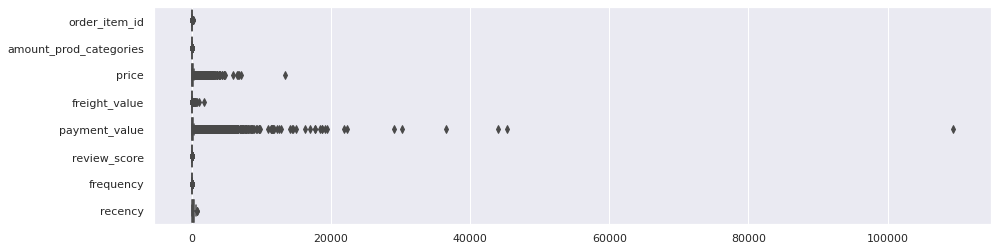

Index(['customer_id', 'order_item_id', 'amount_prod_categories', 'price',
       'freight_value', 'payment_value', 'review_score', 'frequency',
       'recency'],
      dtype='object')


In [0]:
plt.figure(figsize = (15,4))
sns.boxplot(data = alldata, orient = "h")
plt.show()
print(alldata.columns)

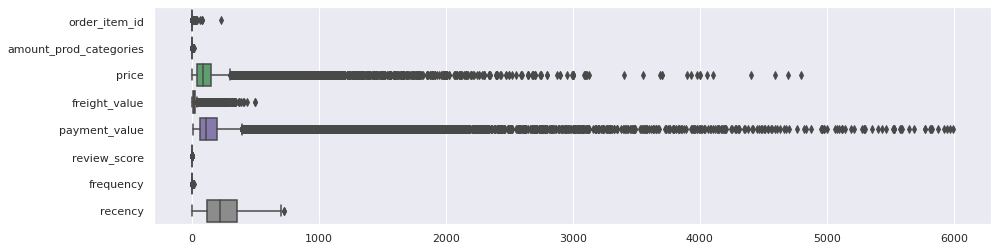

In [0]:
plt.figure(figsize = (15,4))
sns.boxplot(data = alldata2, orient = "h")
plt.show()

In [0]:
alldata.iloc[83916,:]

customer_id               07c031e9f5c32ee5a8d05a52e646eb2d
order_item_id                                            1
amount_prod_categories                                   1
price                                                209.9
freight_value                                        20.01
payment_value                                       229.91
review_score                                             5
frequency                                                1
recency                                                332
Name: 46571, dtype: object

In [0]:
from collections import Counter


def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 8 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 1 outlier
    outlier_indices = Counter(outlier_indices)        
  

    return outlier_indices

# detect outliers from list of features
lof = [ 'price', 'payment_value']
Outliers_to_drop = detect_outliers(alldata, 1, lof)

print(len(Outliers_to_drop))


1895


In [0]:
alldata = alldata.drop(Outliers_to_drop)


In [0]:
print(alldata.shape)

(96770, 9)


In [0]:
alldata2.to_csv('Main_OList_Data.csv')

# 3. Data exploration

## 3.1.1 Reviews statistics 

In [0]:
best_noted_sellers = gb_seller[:1000]
best_sellers = best_noted_sellers[['seller_id','review_score','total_revenue']]


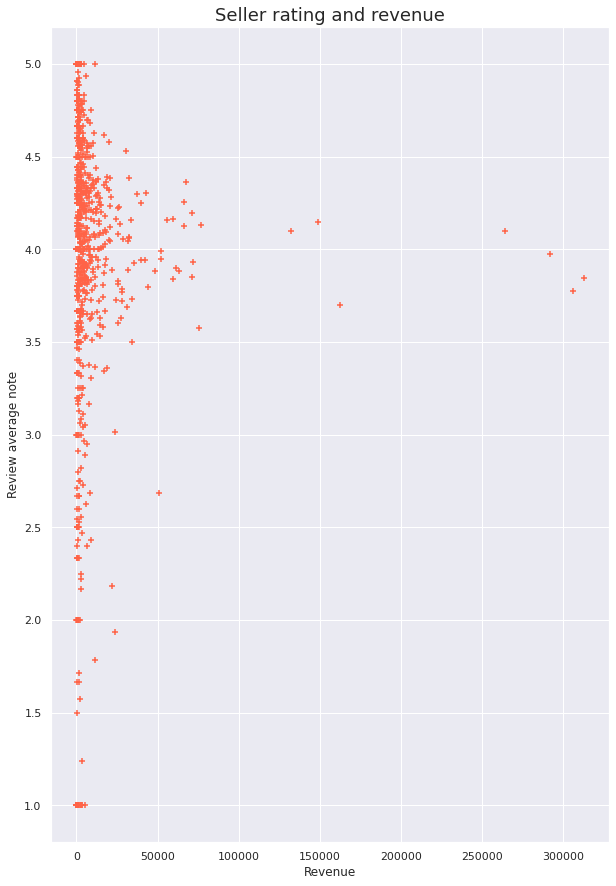

In [0]:
sellerpop = plt.scatter( y=best_sellers['review_score'], x=best_sellers["total_revenue"],marker = '+', color = 'tomato');
sns.set_context("talk")
plt.xlabel('Revenue')
plt.ylabel('Review average note')
plt.title('Seller rating and revenue')
plt.show()

In [0]:
customer_satisfaction = alldata.sort_values(by=['review_score'], ascending=False)

Text(0, 0.5, 'Customer cumulative frequency')

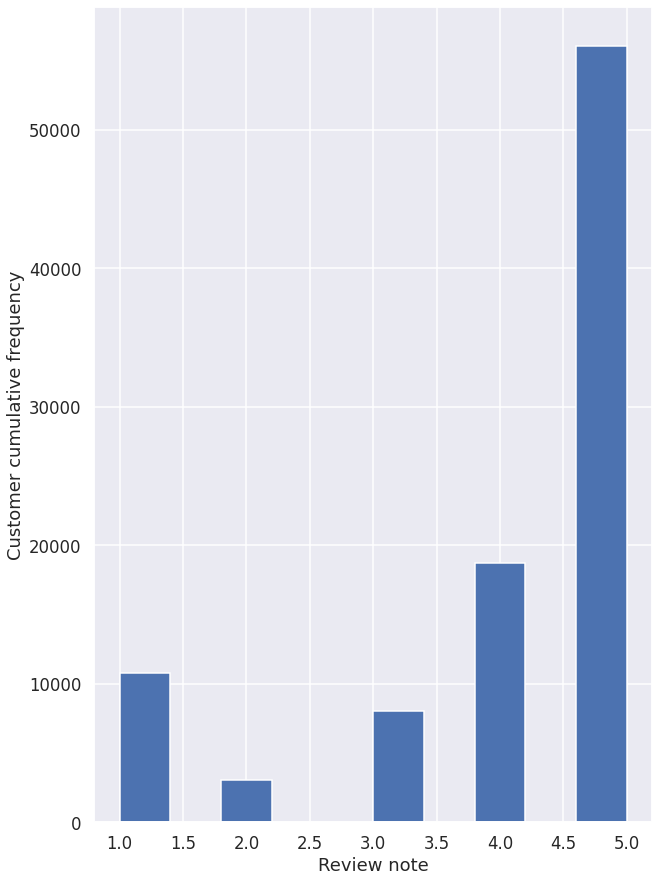

In [0]:
satisfactiongraph = plt.hist(customer_satisfaction['review_score'])
plt.xlabel('Review note')
plt.ylabel('Customer cumulative frequency')

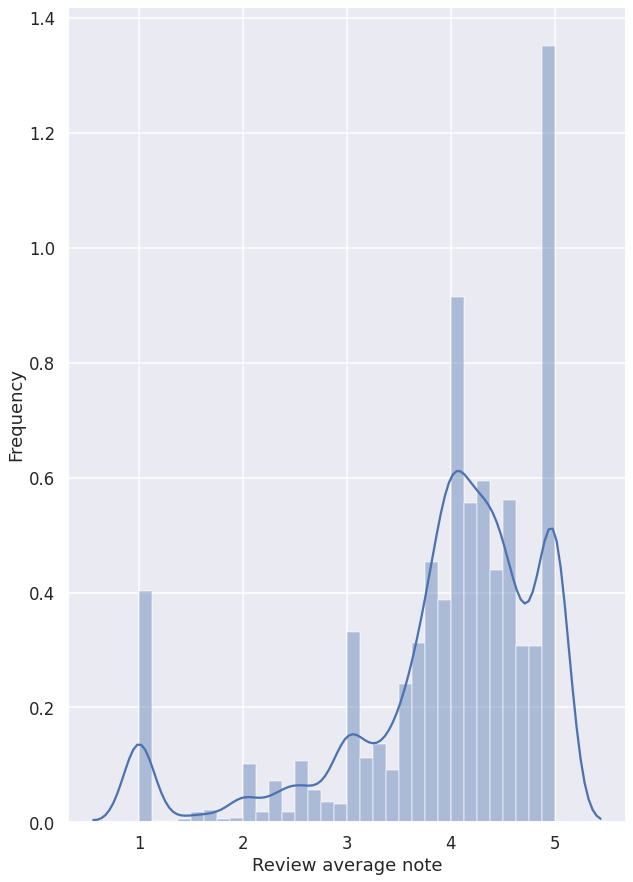

In [0]:
satisfactiongraph = sns.distplot(gb_seller['review_score'])
plt.xlabel('Review average note')
plt.ylabel('Frequency')
plt.show()

## 3.1.2 Product categories popularity

Visualize the amount of items in each category

In [0]:
df_reviews_by_customer['product_category_name_english'].fillna("None", inplace = True) 
 

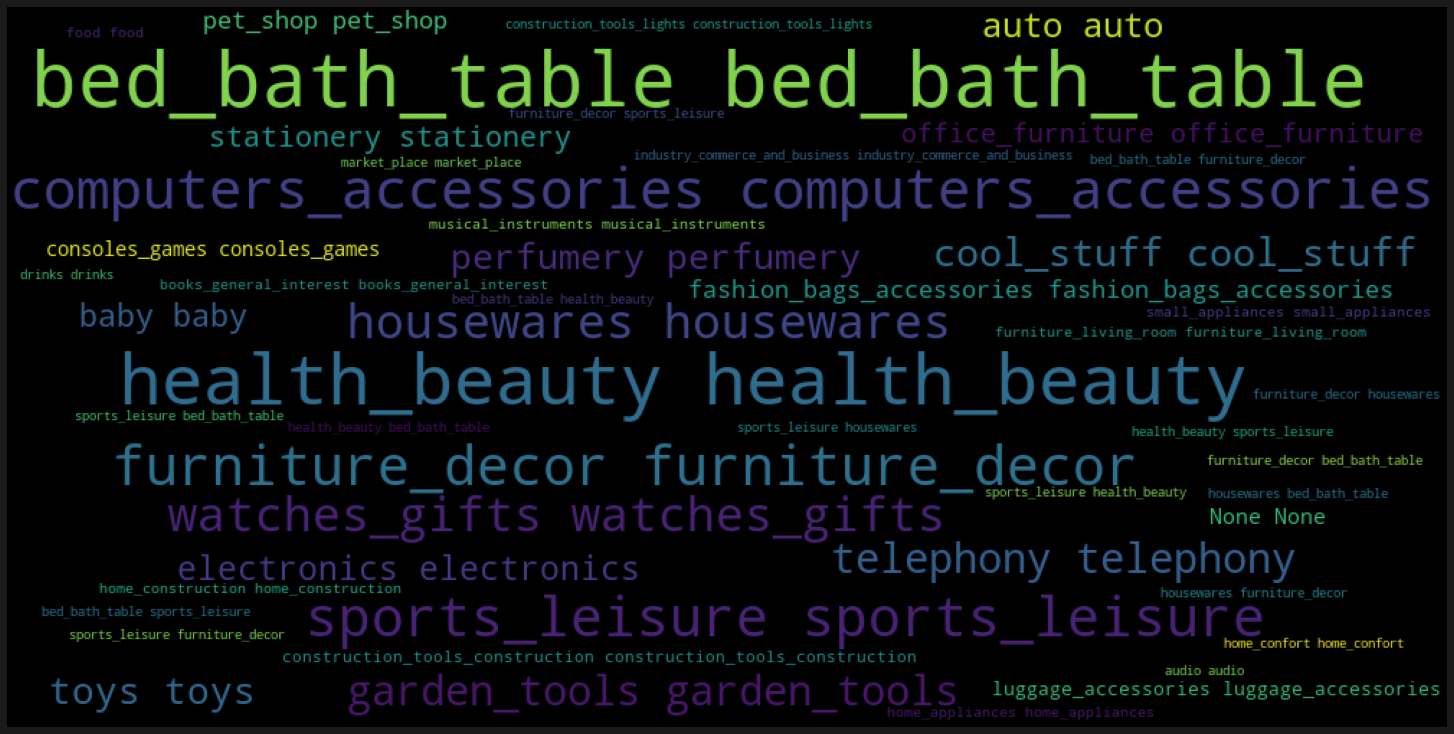

In [0]:
import seaborn as sns
from wordcloud import WordCloud
soup = ' '.join(df_reviews_by_customer['product_category_name_english'])
#wordcloud = WordCloud().generate()

wordcloud = WordCloud(width=1000, height=500,max_words=50)
wordcloud.generate(soup)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [0]:
product_rew = df_reviews_by_customer.groupby(['product_category_name_english']).mean().reset_index()
product_rew = product_rew.sort_values(by=['review_score'], ascending=False)

best_noted_products = product_rew[:10]
best_noted_products = best_noted_products[['product_category_name_english','review_score']]
best_noted_products[:2]

,product_category_name_english,review_score
12,cds_dvds_musicals,4.642857
30,fashion_childrens_clothes,4.500000


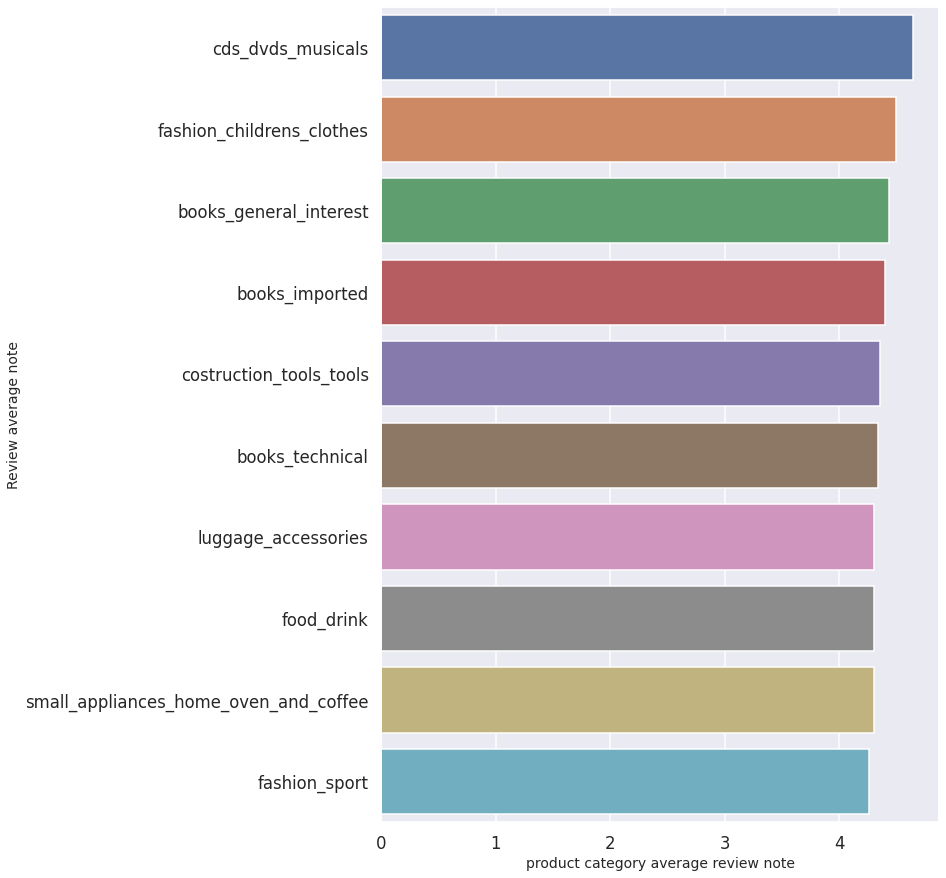

In [0]:
prodnote_hist = sns.barplot( y=best_noted_products["product_category_name_english"], x=best_noted_products["review_score"]);
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
plt.xlabel('product category average review note', fontsize = 14)
plt.ylabel('Review average note', fontsize = 14)
plt.show()

In [0]:
prodcat = df_reviews_by_customer.groupby(['product_category_name_english']).sum().reset_index() 
prodcat = prodcat[prodcat['product_category_name_english'] != 'None']
prodcat = prodcat.sort_values(by=['order_item_id'], ascending=False)
prodcat.head()

,product_category_name_english,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,review_score
8,bed_bath_table,374793596,14080,42741,1744205.53,13913,1051085.50,207310.74,43636
40,furniture_decor,311959910,9737,27681,1444383.69,11664,736682.46,174420.67,32716
44,health_beauty,345872367,10554,30329,1663076.30,11135,1263102.57,183488.76,40118
66,sports_leisure,319983379,9540,22579,1400270.11,10002,993684.51,169692.51,35616
16,computers_accessories,295317493,8566,18458,1599574.66,9960,919721.44,148442.64,30953


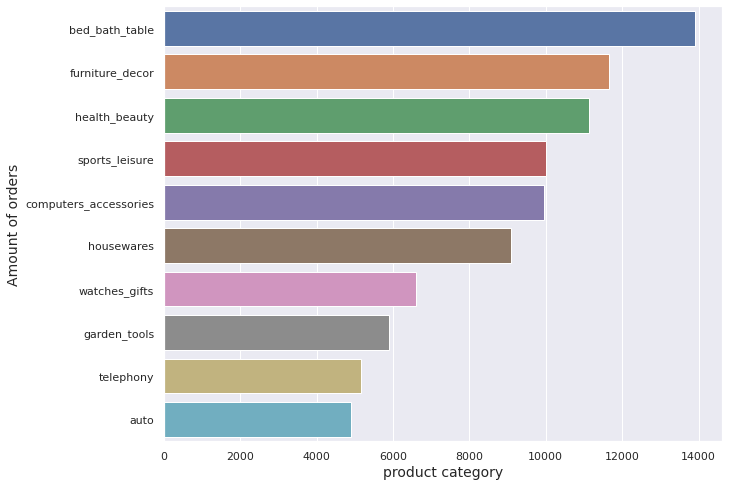

In [0]:
prodcat0 = prodcat[:10]

sns.set_context("talk")
sns.set_style("white")
sns.set(rc={'figure.figsize':(10,8)})
catorderhist = sns.barplot( y=prodcat0["product_category_name_english"], x=prodcat0["order_item_id"] );

plt.xlabel('product category', fontsize = 14)
plt.ylabel('Amount of orders', fontsize = 14)
plt.show()

In [0]:
prodcat = prodcat.sort_values(by=['payment_value'], ascending=False)
prodcat1 = prodcat[:10]

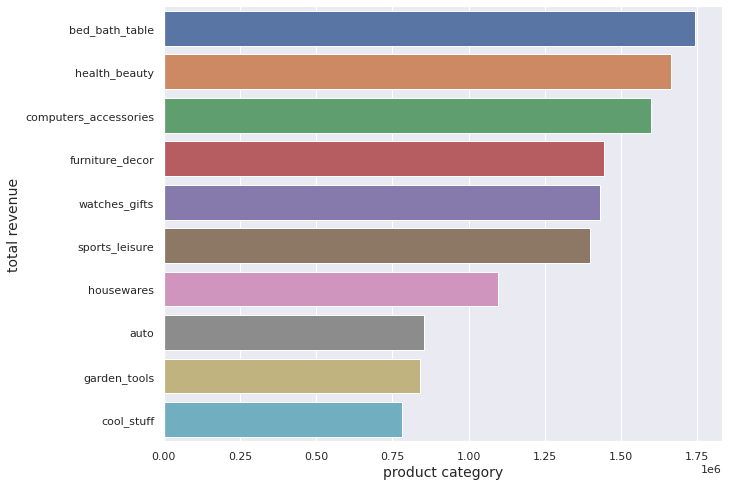

In [0]:
cat_revenue_hist = sns.barplot( y=prodcat1["product_category_name_english"], x=prodcat1["payment_value"] );
sns.set(rc={'figure.figsize':(10,15)})
plt.xlabel('product category', fontsize = 14)
plt.ylabel('total revenue', fontsize = 14)
plt.show()

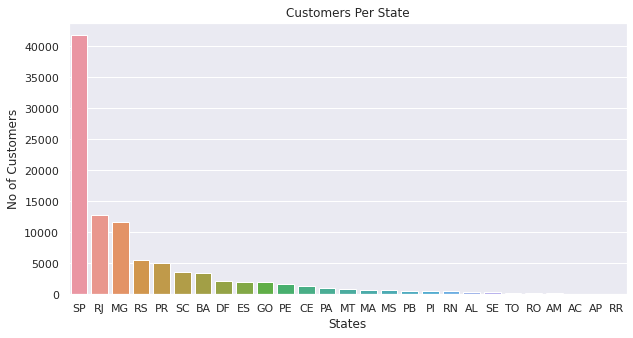

In [0]:
plt.figure(figsize=(10,5))
plt.title('Customers Per State')
plt.ylabel('No of Customers')
plt.xlabel('States')
sns.barplot(x=df_customers['customer_state'].value_counts().index,y=df_customers['customer_state'].value_counts().values)

## 3.2 RFM analysis

In [0]:
alldata.columns

Index(['customer_id', 'order_item_id', 'amount_prod_categories', 'price',
       'freight_value', 'payment_value', 'review_score', 'frequency',
       'recency'],
      dtype='object')

In [0]:
transaction_data = alldata[['customer_id','frequency','recency','payment_value']]
## convert timestamp to date; only need the day
#transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
#transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
print(transaction_data.shape)
transaction_data.head()

(96770, 4)


,customer_id,frequency,recency,payment_value
38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96
27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08
80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60
5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18
25363,109f80397e4897bbcf56313c25850332,6,112,1157.04


Now that I have my transaction data, I want to convert this into dataframe with the RFM variables. For that I use python Lifetimes package. The Lifetimes package has a function for converting transaction data into an RFM DataFrame

In [0]:
df_RFM = transaction_data.rename(columns={"payment_value": "monetary_value"})
df_RFM = df_RFM.reset_index()

In [0]:
df_RFM.head()

,index,customer_id,frequency,recency,monetary_value
0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96
1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08
2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60
3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18
4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04



    frequency: # of days in which a customer made a repeat purchase
    T: customer's age in days
    recency: customer's age in days at time of most recent purchase
    monetary_value: sum of a customer's purchases



In [0]:
print(df_RFM.shape)
print(df_RFM.columns)
print(df_RFM['frequency'].value_counts())
print(df_RFM['recency'].value_counts())
print(df_RFM['monetary_value'].value_counts())

(96770, 5)
Index(['index', 'customer_id', 'frequency', 'recency', 'monetary_value'], dtype='object')
1    87510
2     7708
3     1093
4      333
5       70
6       55
8        1
Name: frequency, dtype: int64
282    1063
283     437
281     422
280     399
279     379
       ... 
728       2
603       2
618       1
700       1
0         1
Name: recency, Length: 614, dtype: int64
77.57      253
35.00      166
73.34      162
116.94     129
56.78      122
          ... 
639.60       1
240.17       1
306.75       1
108.03       1
1024.00      1
Name: monetary_value, Length: 28505, dtype: int64


In [0]:
# filter out one time buyers : customers with 0 monetary_value, frequency and recency
df_RFM = df_RFM[df_RFM['frequency']>0]
df_RFM.describe()

,index,frequency,recency,monetary_value
count,96770.000000,96770.000000,96770.000000,96770.000000
mean,49337.110912,1.118373,244.800434,162.523740
std,28476.524071,0.409977,153.357231,168.489635
min,0.000000,1.000000,0.000000,9.590000
25%,24680.250000,1.000000,121.000000,62.250000
50%,49337.500000,1.000000,226.000000,107.780000
75%,73997.750000,1.000000,355.000000,189.190000
max,98664.000000,8.000000,728.000000,1265.480000


In [0]:
quintiles = df_RFM[['recency', 'frequency', 'monetary_value']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary_value': {0.2: 54.53,
  0.4: 86.74,
  0.6: 133.85,
  0.8: 218.21000000000004},
 'recency': {0.2: 100.0, 0.4: 184.0, 0.6: 275.0, 0.8: 390.0}}

I write methods to assign ranks from 1 to 5. A smaller Recency value is better whereas higher Frequency and Monetary values are better. I need to write two separate methods.

In [0]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [0]:
#  R, F and M scores of each customer.
df_RFM['R'] = df_RFM['recency'].apply(lambda x: r_score(x))
df_RFM['F'] = df_RFM['frequency'].apply(lambda x: fm_score(x, 'frequency'))
df_RFM['M'] = df_RFM['monetary_value'].apply(lambda x: fm_score(x, 'monetary_value'))

Finally, I combine the R, F and M scores into a RFM Score

In [0]:
df_RFM['RFM Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)
df_RFM.head()

,index,customer_id,frequency,recency,monetary_value,R,F,M,RFM Score
0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96,2,5,5,255
1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08,4,5,5,455
2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60,5,5,5,555
3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18,1,5,5,155
4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04,4,5,5,455


The RFM scores give us too many segments if I would take each individual values. Which is not easy to work with.
I am going to work with 11 segments based on the R and F scores. Here is the description of the segments:

Champions: Bought recently, buy often and spend the most

Loyal Customers: buy on a regular basis. Responsive to promotions.

Potential Loyalist: Recent customers with average frequency.

Recent Customers:   Bought most recently, but not often.

Promising:    Recent shoppers, but haven’t spent much.

Customers Needing Attention: Above average recency, frequency and monetary values. May not have bought very recently though.

About To Sleep: Below average recency and frequency. Will lose them if not reactivated.

At Risk: Purchased often but a long time ago. Need to bring them back!

Can’t Lose Them: Used to purchase frequently but haven’t returned for a long time.

Hibernating: Last purchase was long back and low number of orders. May be lost.

In [0]:


segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t lose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

df_RFM['Segment'] = df_RFM['R'].map(str) + df_RFM['F'].map(str)
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex=True)
df_RFM.to_csv('RFM_OList_Data.csv')
df_RFM.head()



,index,customer_id,frequency,recency,monetary_value,R,F,M,RFM Score,Segment
0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96,2,5,5,255,can't lose
1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08,4,5,5,455,loyal customers
2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60,5,5,5,555,champions
3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18,1,5,5,155,can't lose
4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04,4,5,5,455,loyal customers


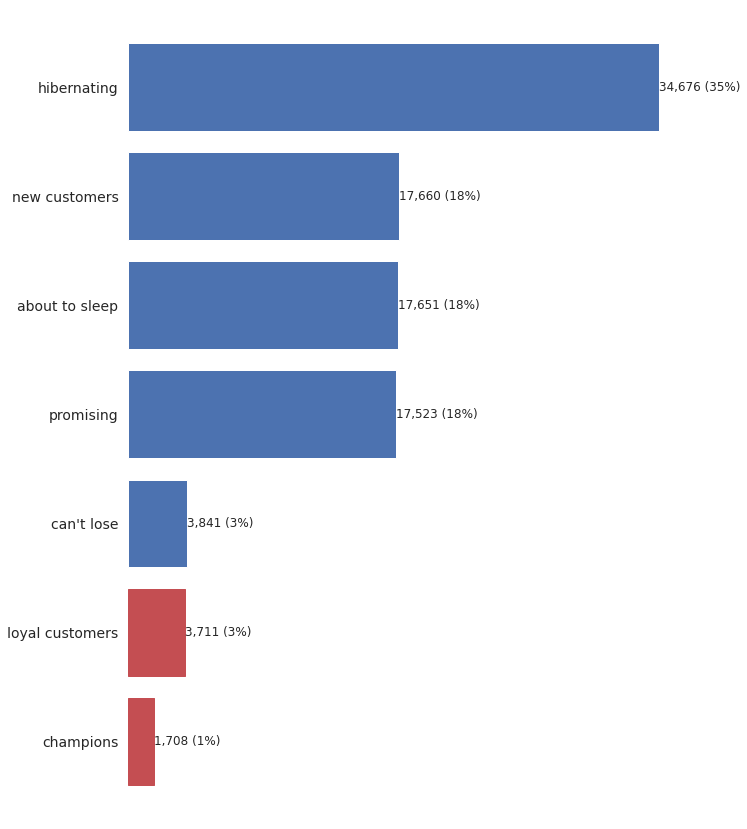

In [0]:
# count the number of customers in each segment
segments_counts = df_RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='b')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('r')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={'figure.figsize':(5,10)})
plt.show()